In [47]:
import numpy as np
import cv2
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import streamlit as st
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image

In [48]:
from sklearn.datasets import fetch_olivetti_faces
data = fetch_olivetti_faces(shuffle=True, random_state=42)
images = data.images  # Images are 64x64
print(f"Original images shape: {images.shape}")

Original images shape: (400, 64, 64)


In [49]:
# Define the desired low-resolution size
low_res_size = (32, 32)

# Create Low-Resolution (LR) and High-Resolution (HR) pairs
low_res_images = []
high_res_images = []

for img in images:
    # Convert from (64x64) to (32x32)
    low_res = cv2.resize(img, low_res_size, interpolation=cv2.INTER_AREA)
    low_res_images.append(low_res)

    # Keep original (64x64) as high-res
    high_res_images.append(img)

# Convert lists to NumPy arrays
low_res_images = np.array(low_res_images)
high_res_images = np.array(high_res_images)

print(f"Low-resolution images shape: {low_res_images.shape}")
print(f"High-resolution images shape: {high_res_images.shape}")


Low-resolution images shape: (400, 32, 32)
High-resolution images shape: (400, 64, 64)


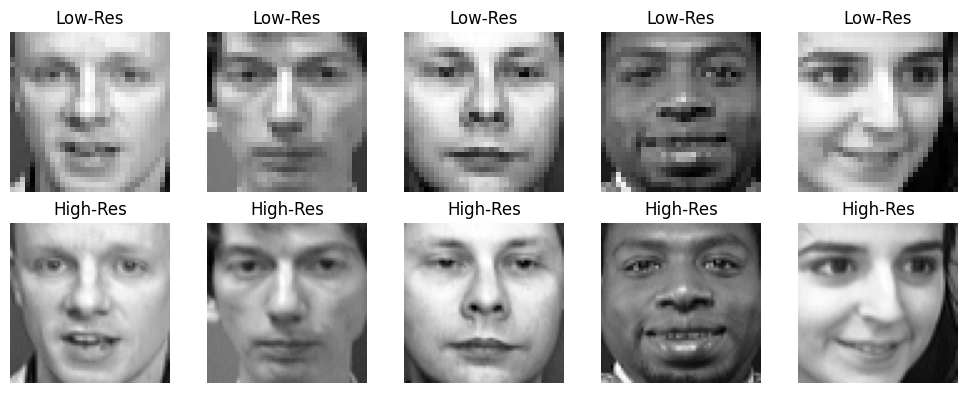

In [50]:
# Display a few examples of LR and HR pairs
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    # Low-resolution images
    axes[0, i].imshow(low_res_images[i], cmap='gray')
    axes[0, i].set_title("Low-Res")
    axes[0, i].axis('off')

    # High-resolution images
    axes[1, i].imshow(high_res_images[i], cmap='gray')
    axes[1, i].set_title("High-Res")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [51]:
# Normalize images to [0, 1]
low_res_images = low_res_images.astype(np.float32) / 255.0
high_res_images = high_res_images.astype(np.float32) / 255.0

print("Normalization completed.")


Normalization completed.


In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D

def build_super_resolution_model(input_shape):
    model = Sequential([
        # Feature extraction
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Upsampling
        UpSampling2D(size=(2, 2)),
        Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ])
    return model

model = build_super_resolution_model((32, 32, 1))  # Input shape for low-res images
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,145 (149.00 KB)

 Trainable params: 38,145 (149.00 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
low_res_images = np.expand_dims(low_res_images, axis=-1)  # Shape: (400, 32, 32, 1)
high_res_images = np.expand_dims(high_res_images, axis=-1)  # Shape: (400, 64, 64, 1)


In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    low_res_images, high_res_images, test_size=0.2, random_state=42
)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (320, 32, 32, 1)
Testing data shape: (80, 32, 32, 1)


In [55]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16
)


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 428ms/step - loss: 0.2240 - mae: 0.4715 - val_loss: 0.0594 - val_mae: 0.2414
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 319ms/step - loss: 0.0265 - mae: 0.1391 - val_loss: 6.1519e-04 - val_mae: 0.0109
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - loss: 4.3819e-04 - mae: 0.0078 - val_loss: 2.1097e-04 - val_mae: 0.0043
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 378ms/step - loss: 1.9528e-04 - mae: 0.0042 - val_loss: 1.6531e-04 - val_mae: 0.0040
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - loss: 1.6045e-04 - mae: 0.0039 - val_loss: 1.4800e-04 - val_mae: 0.0039
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - loss: 1.4477e-04 - mae: 0.0038 - val_loss: 1.3501e-04 - val_mae: 0.0038
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 353ms/step - loss: 1.3216e-04 - mae: 0.0038 - val_loss: 1.2348e-04 - val_mae: 0.0037
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - loss: 1.2100e-04 - mae: 0.0037 - val_loss: 1.1304e-04 - val_mae: 0.00

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


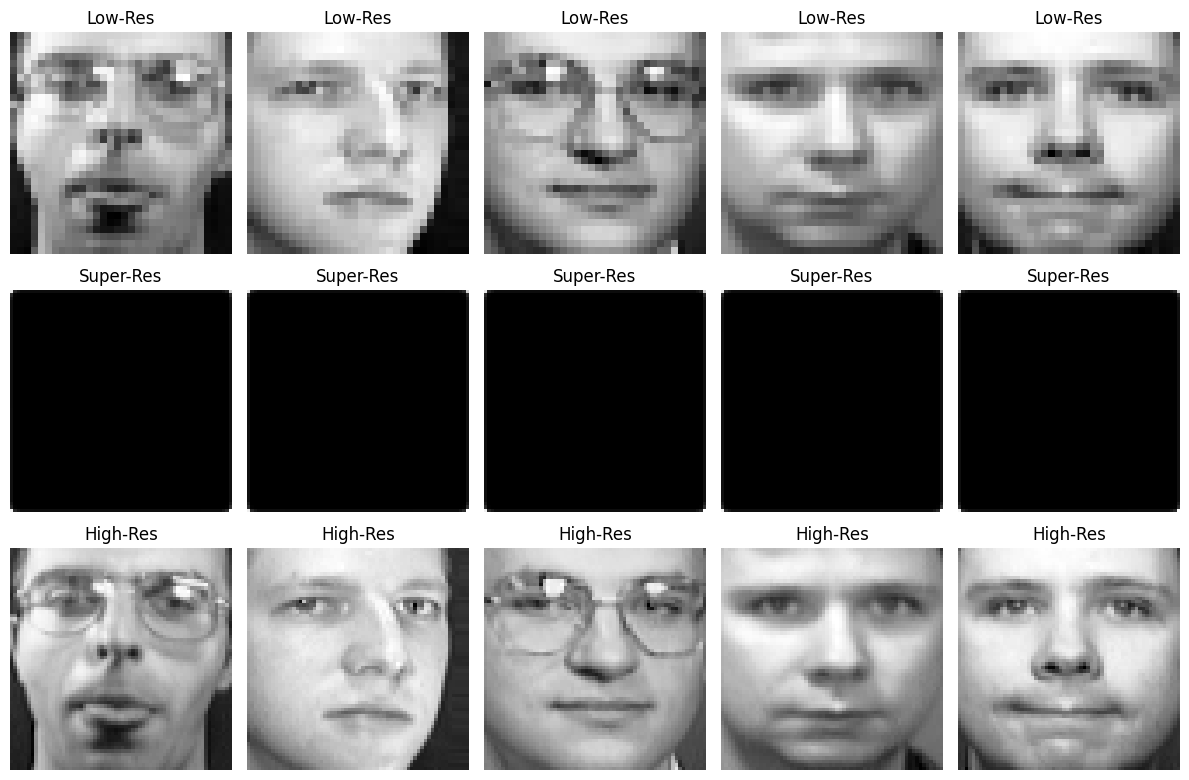

In [56]:
# Test the model on a few low-res images
predictions = model.predict(X_test[:5])

# Visualize results
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for i in range(5):
    # Low-resolution input
    axes[0, i].imshow(X_test[i].squeeze(), cmap='gray')
    axes[0, i].set_title("Low-Res")
    axes[0, i].axis('off')

    # Super-resolved output
    axes[1, i].imshow(predictions[i].squeeze(), cmap='gray')
    axes[1, i].set_title("Super-Res")
    axes[1, i].axis('off')

    # High-resolution ground truth
    axes[2, i].imshow(y_test[i].squeeze(), cmap='gray')
    axes[2, i].set_title("High-Res")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


In [57]:
# Save the model
model.save('super_resolution_model.h5')
